Phase shift extraction code from interference data

Imports and adding path

In [217]:
# add path:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) # Go up two levels from current path (from src/ to project root)
sys.path.append(project_root)
# add my library:
import global_utils
import constants
print(constants.__file__)
import global_functions_im
# run this command to install all requirements:
#       pip install -r project_abel/requirements.txt
#       for pyAble a lower version of python is needed
# miscellaneous imports:
import matplotlib.pyplot as plt
import tifffile as tiff # Loads .tiff as a NumPy array
import numpy as np # low level image manipulation (matrix)
import cmasher as cmr # extra colormaps
from cmap import Colormap
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from skimage.feature import peak_local_max
from skimage.restoration import unwrap_phase
from scipy.ndimage import gaussian_filter

C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\constants.py


Choosing path

In [218]:
path = constants.base_dir
folders = global_utils.get_folder_names(path)
folders2 = global_utils.get_folder_names(path + "\\" + folders[1])
folders3 = global_utils.get_folder_names(path + "\\" + folders[1] + "\\" + folders2[0])
folders4 = global_utils.get_folder_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0])
print(folders)
print(folders2)
print(folders3)
print(folders4)
# files
print("--- Files ---")
files_img = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[1] + "\\" + folders4[0])
files_ref = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[9])
# print(files_img)
# print(files_ref)
# path creation
img_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[0] + "\\" + files_img[7]
ref_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[9] + "\\" + files_ref[0]
# --- x2 ---
# files_img = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[2])
# img_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[2] + "\\" + files_img[0]
# files_ref = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[8])
# ref_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[8] + "\\" + files_ref[1]
# 1x ------
# files_img = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[6])
# img_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[6] + "\\" + files_img[0]
# files_ref = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[7])
# ref_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[7] + "\\" + files_ref[1]
print(img_path)
print(ref_path)

['IDEA program+ cvicna data', 'Images', 'Spectra']
['1064 nm', '2090 nm']
['H0_3_28_25', 'H6_3_31_25']
['(1) 50-1000ns', '(2) 1000 - 2000 ns', '(3) 2-5us', '(4) 5-14.5us', '(5) 15-100us', '(6) 100-525us', '(7) 500us-2ms', 'reference x1', 'reference x2', 'reference x4', 'wrong beginning']
--- Files ---
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\1064 nm\H0_3_28_25\(1) 50-1000ns\M10_X16.tif
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\1064 nm\H0_3_28_25\reference x4\REF_X1.tif


Loading practice data

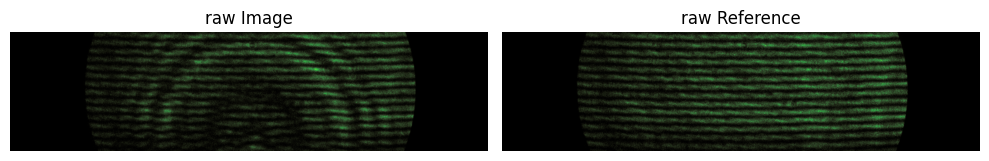

In [219]:
img = tiff.imread(img_path)
ref = tiff.imread(ref_path)

colormap = cmr.nuclear
def plot_two_images(img1, img2, title1='Image 1', title2='Image 2', cmap='cmr.nuclear'):
    # Get colormap from cmasher
    comap = eval(cmap) if isinstance(cmap, str) else cmap

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img1, cmap=comap)
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(img2, cmap=comap)
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

plot_two_images(img, ref, title1='raw Image', title2='raw Reference',cmap=colormap)
# global_functions_im.plot_two_images(img, ref, title1='raw Image', title2='raw Reference',cmap=colormap)

Auto crop function with a constant size for:
x4: 721 px - 40 px
x2: 433 px - 20 px
x1: 235 px - 20 px

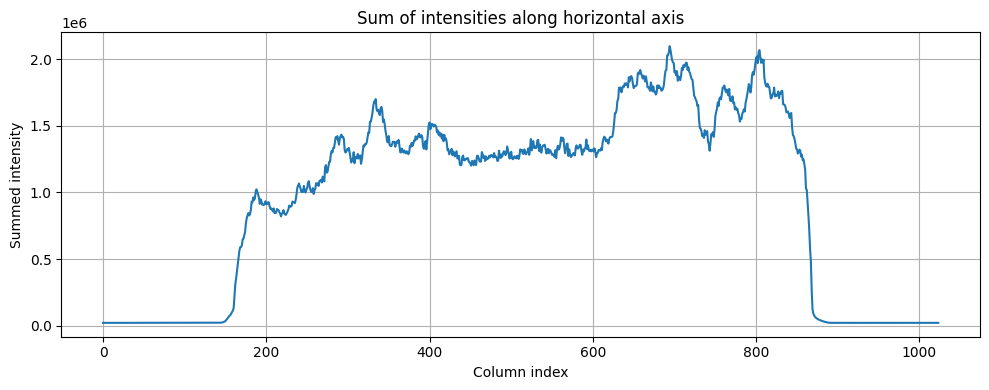

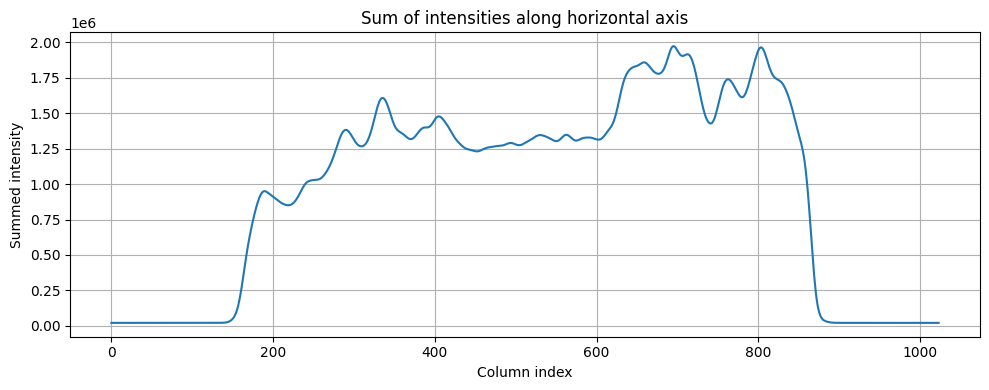

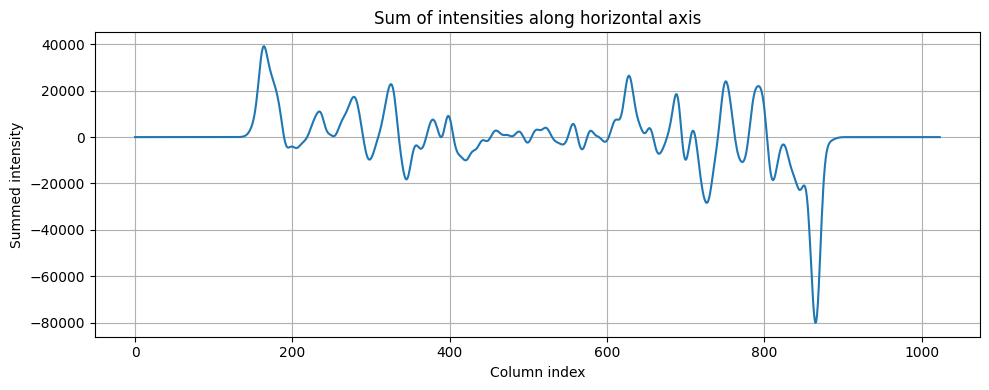

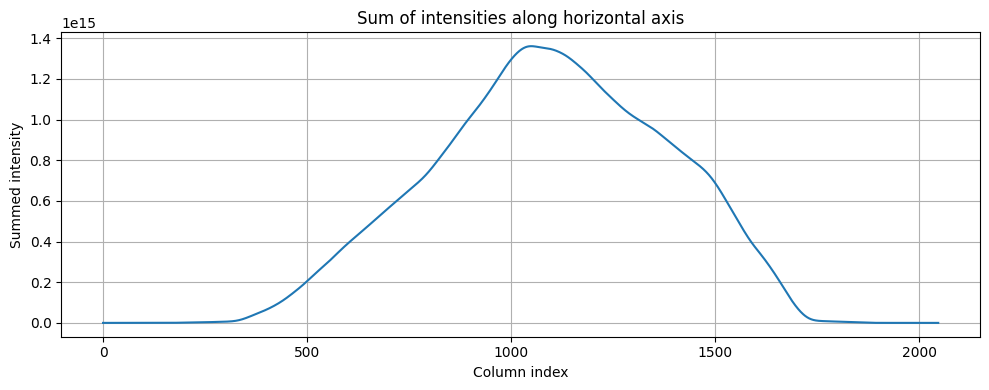

498
513
152 875


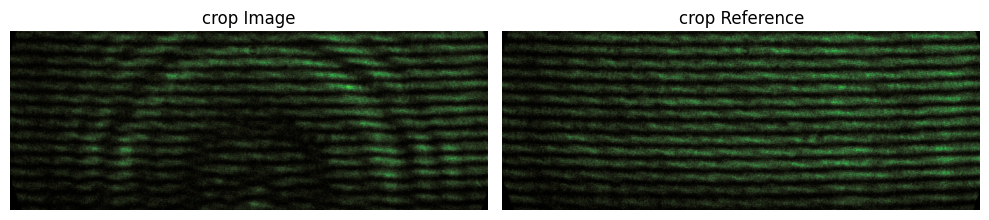

In [220]:
def get_horizontal_intensity_sum(image):
    """
    Makes sum in the horizontal direction of an image intensity.
    :param image: numpy
    """
    return image.sum(axis=0)

def plot_intensity(profile):
    """
    Plots the sum.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(profile)
    plt.title("Sum of intensities along horizontal axis")
    plt.xlabel("Column index")
    plt.ylabel("Summed intensity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def smooth_profile(profile, sigma = 2):
    return gaussian_filter1d(profile, sigma)

def calculate_gradient(profile, sigma):
    smoothed = smooth_profile(profile, sigma)
    return np.gradient(smoothed)

def detect_edges(profile, smoothing_sigma=5, threshold_ratio=0.3):
    """
    Detect the left and right edges in a 1D intensity profile.

    Parameters
    profile : 1D array of summed intensities
    smoothing_sigma : float smoothing parameter for gaussian_filter1d
    threshold_ratio : float fraction of peak gradient to use as threshold

    Returns
    left_edge, right_edge : integer indices of the first rising edge
                            and the last falling edge
    """
    # smooth the profile to suppress noise
    smooth = gaussian_filter1d(profile, sigma=smoothing_sigma)

    # compute its gradient
    grad = np.gradient(smooth)

    # dynamic thresholds
    pos_thr = grad.max() * threshold_ratio
    neg_thr = grad.min() * threshold_ratio

    # first rising edge
    rising = np.where(grad > pos_thr)[0]
    left_edge = int(rising[0]) if rising.size else 0

    # last falling edge
    falling = np.where(grad < neg_thr)[0]
    right_edge = int(falling[-1]) if falling.size else profile.size - 1

    return left_edge, right_edge

def center_by_symmetry(profile, smoothing_sigma=5):
    """
    Find the horizontal center of maximal left-right symmetry in a 1D profile.
    """
    # smooth the profile to suppress noise
    smooth = gaussian_filter1d(profile, sigma=smoothing_sigma)
    # full cross correlation with its own reversed copy
    corr = correlate(smooth, smooth[::-1], mode='full')
    plot_intensity(corr)
    # length of the original profile
    n = smooth.size
    # index of maximum correlation
    lag = np.argmax(corr)
    # convert lag to center coordinate
    # for profile length n the formula is (2n - 2 - lag) / 2
    center = int((2 * n - 2 - lag) / 2)
    return center

def plot_image(image, title='', cmap='viridis'):
    """
    Display a single image with no axes, custom title, and custom colormap.

    Parameters:
    - img: 2D or 3D array-like image data
    - title: string for the plot title
    - cmap: string name of the matplotlib colormap
    """
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# cropping
def crop_from_center(image, sx, width, height, sy=None):
    """
    Crop img around horizontal center Sx and vertical center Sy.
    If Sy is None the crop is taken from the top (y=0).
    """
    h, w = image.shape[:2]
    x0 = max(sx - width//2, 0)
    x1 = min(sx + width//2, w)
    if sy is None:
        y0, y1 = 0, min(height, h)
    else:
        y0 = max(sy - height//2, 0)
        y1 = min(sy + height//2, h)
    return image[y0:y1, x0:x1]

profile1 = get_horizontal_intensity_sum(img)
plot_intensity(profile1)
smoothed1 = smooth_profile(profile1, sigma = 5)
plot_intensity(smoothed1)
grad1 = calculate_gradient(profile1, sigma = 5)
plot_intensity(grad1)
center1 = center_by_symmetry(profile1, smoothing_sigma=10)
print(center1)
# detect edges
l, r = detect_edges(profile1, smoothing_sigma=6, threshold_ratio=0.3)
# now you can compute the center or feed l and r into a crop function
print((l + r) // 2) 
print(l,r)
# crop
sx = (l + r) // 2
wid = r - l - 40 # r - l - #px
hei = img.shape[0]
crop_img = crop_from_center(img, sx, wid, hei)
crop_ref = crop_from_center(ref, sx, wid, hei)
colormap = cmr.nuclear
#
plot_two_images(crop_img, crop_ref, title1='crop Image', title2='crop Reference',cmap=colormap)

Padding image

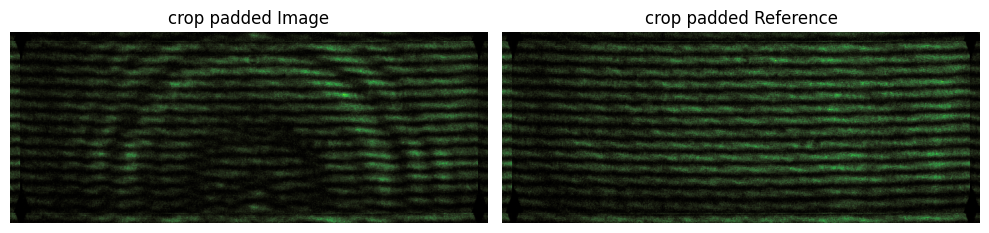

In [221]:
p = 15
padded_img = np.pad(crop_img, pad_width = p, mode = 'wrap') # constant, wrap, symmetric
padded_ref = np.pad(crop_ref, pad_width = p, mode = 'wrap') # constant, wrap, symmetric
plot_two_images(padded_img, padded_ref, title1='crop padded Image', title2='crop padded Reference',cmap=colormap)

Fourier transform visualisation

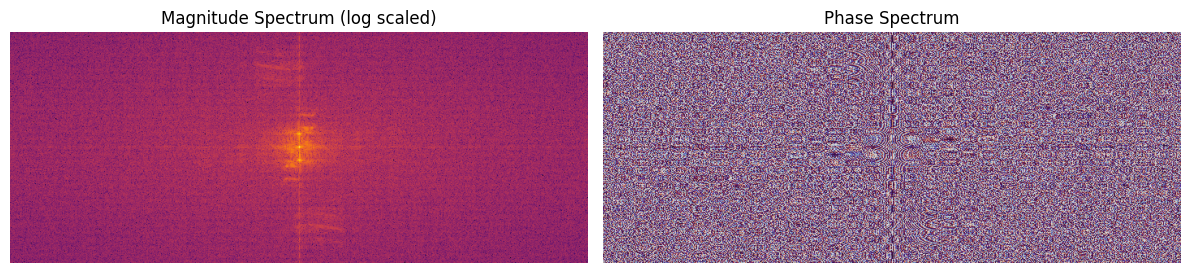

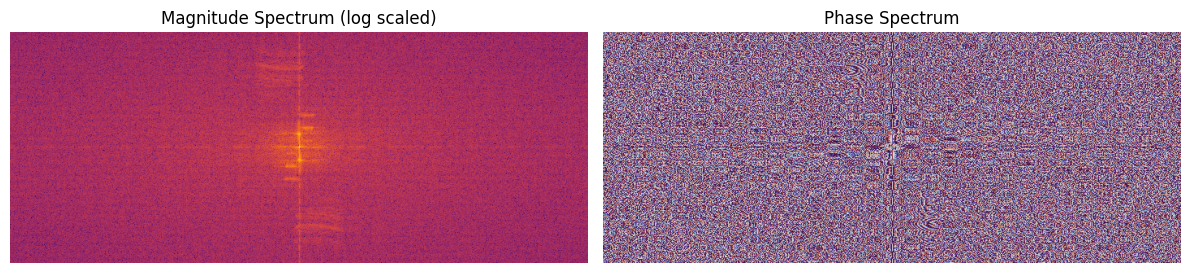

In [222]:
def plot_fft_spectra(
    image,
    log_scale=True,
    cmap_mag='inferno',
    cmap_phase='twilight',
    figsize=(12, 6)
):
    """
    Compute FFT magnitude and phase spectra of an image and display them side by side.

    Parameters
    ----------
    image : array_like
        Original image array.
    log_scale : bool, optional
        If True, apply log scaling to magnitude spectrum.
    cmap_mag : str, optional
        Colormap for magnitude spectrum.
    cmap_phase : str, optional
        Colormap for phase spectrum.
    figsize : tuple, optional
        Figure size for the plots.
    """

    # Compute FFT and shift zero frequency component to center
    fft_image = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_image)

    # Compute magnitude spectrum
    magnitude = np.log1p(np.abs(fft_shifted)) if log_scale else np.abs(fft_shifted)

    # Compute phase spectrum
    phase = np.angle(fft_shifted)

    # Plot both spectra
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(magnitude, cmap=cmap_mag)
    axes[0].set_title("Magnitude Spectrum (log scaled)" if log_scale else "Magnitude Spectrum")
    axes[0].axis('off')

    axes[1].imshow(phase, cmap=cmap_phase)
    axes[1].set_title("Phase Spectrum")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


plot_fft_spectra(padded_img)
plot_fft_spectra(padded_ref)

Fourier transform - automatic phase extraction pt1
1. Function for FFT
2. Function to find diffraction peaks
3. Function for elliptical mask
4. Extract phase

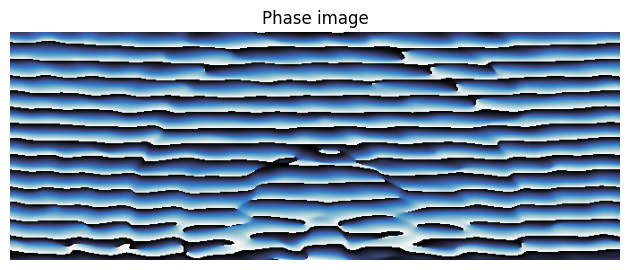

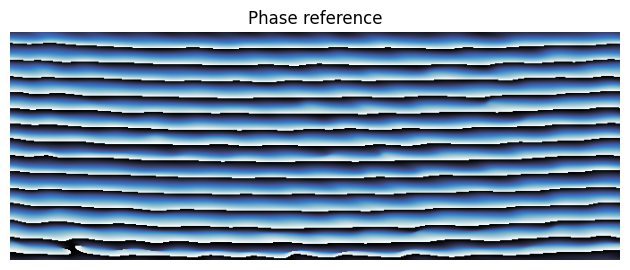

In [223]:
def find_fourier_peaks(
    image: np.ndarray,
    *,
    sigma: float = 3.0,
    min_distance: int = 10,
    threshold_rel: float = 0.3
) -> dict:
    """
    Compute the 2D FFT of a padded image, then locate the 0th and ±1st order peaks.

    Parameters
    ----------
    image : 2D ndarray
        Spatial-domain image (e.g., zero-padded grayscale array).
    sigma : float
        Gaussian smoothing sigma before peak detection in frequency domain.
    min_distance : int
        Minimum pixel distance between detected peaks.
    threshold_rel : float
        Relative intensity threshold for peak detection.

    Returns
    -------
    dict
        {
            'center': (row, col),
            'plus1':  (row, col),
            'minus1': (row, col)
        }
    """
    # 1. forward FFT and shift zero-frequency to center
    F = np.fft.fftshift(np.fft.fft2(image))

    # 2. use magnitude for peak detection
    mag = np.abs(F)

    # 3. smooth and normalize
    sm = gaussian_filter(mag, sigma=sigma)
    if sm.max() > 0:
        sm /= sm.max()

    # 4. find candidate peaks in magnitude spectrum
    peaks = peak_local_max(
        sm,
        min_distance=min_distance,
        threshold_rel=threshold_rel,
        num_peaks=9
    )
    if peaks.shape[0] < 3:
        raise RuntimeError("Failed to detect at least three Fourier peaks")

    rows, cols = mag.shape
    center_geom = np.array([rows/2, cols/2])

    # 5. identify 0th-order peak (closest to center)
    dists = np.linalg.norm(peaks - center_geom, axis=1)
    idx0 = np.argmin(dists)
    center_peak = peaks[idx0]
    rem = np.delete(peaks, idx0, axis=0)

    # 6. select most opposite pair for ±1 orders
    best_pair = None
    best_score = np.inf
    for i in range(len(rem)):
        for j in range(i+1, len(rem)):
            v1 = rem[i] - center_peak
            v2 = rem[j] - center_peak
            score = np.linalg.norm(v1 + v2)
            if score < best_score:
                best_score = score
                best_pair = (rem[i], rem[j])
    if best_pair is None:
        raise RuntimeError("Could not identify ±1 order peaks")

    # 7. label plus1/minus1 by horizontal position
    p1, p2 = best_pair
    if p1[1] > center_peak[1]:
        plus1, minus1 = p1, p2
    else:
        plus1, minus1 = p2, p1

    return {
        'center':  (int(center_peak[0]), int(center_peak[1])),  
        'plus1':   (int(plus1[0]),       int(plus1[1])),
        'minus1':  (int(minus1[0]),      int(minus1[1]))
    }

def find_fft_peaks_simple(
    img: np.ndarray,
    exclude_radius: int = 10,
    smooth_sigma: float = 0.0
) -> dict:
    """
    Simple detection of the DC and first-order peaks in the FFT magnitude by:
      1. Computing the centered FFT magnitude.
      2. Optionally smoothing it.
      3. Zeroing out a small circular region around DC.
      4. Picking the two brightest remaining pixels as ±1 orders.

    Parameters
    ----------
    img : 2D ndarray
        Spatial-domain (padded) image.
    exclude_radius : int
        Radius (pixels) around the center to mask out DC.
    smooth_sigma : float
        If >0, Gaussian-smooth the magnitude before peak selection.

    Returns
    -------
    dict with keys:
      'center' : (row, col) of DC component,
      'plus1'  : (row, col) of the +1 order peak,
      'minus1' : (row, col) of the -1 order peak.
    """
    # 1. FFT and shift
    F = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(F)

    # 2. optional smoothing
    if smooth_sigma > 0:
        mag = gaussian_filter(mag, sigma=smooth_sigma)

    # 3. center coordinates
    rows, cols = mag.shape
    cy, cx = rows // 2, cols // 2

    # 4. mask out DC region
    y, x = np.ogrid[:rows, :cols]
    dc_mask = (y - cy)**2 + (x - cx)**2 <= exclude_radius**2
    mag_nodc = mag.copy()
    mag_nodc[dc_mask] = 0

    # 5. find two brightest peaks
    flat = mag_nodc.ravel()
    idx1 = np.argmax(flat)
    flat[idx1] = 0  # suppress first peak
    idx2 = np.argmax(flat)

    peak1 = divmod(idx1, cols)
    peak2 = divmod(idx2, cols)

    # classify by x > center
    if peak1[1] > cx:
        plus1, minus1 = peak1, peak2
    else:
        plus1, minus1 = peak2, peak1

    return {
        'center':  (cy, cx),
        'plus1':   plus1,
        'minus1':  minus1
    }


def create_ellipse_mask(
    shape: tuple,
    x_center: float,
    y_center: float,
    a: float,
    b: float,
    sigma: float = 0.0
) -> np.ndarray:
    """
    Create an elliptical mask (optionally Gaussian‐smoothed) for an image.

    Parameters
    ----------
    shape : tuple of int
        The image shape as (rows, cols):
        rows = number of vertical pixels (height),
        cols = number of horizontal pixels (width).
    x_center : float
        X‐coordinate of the ellipse center, i.e. the column index.
    y_center : float
        Y‐coordinate of the ellipse center, i.e. the row index.
    a : float
        Semi‐axis length along the x‐direction (horizontal radius in pixels).
    b : float
        Semi‐axis length along the y‐direction (vertical radius in pixels).
    sigma : float, optional
        If zero, returns a boolean mask. If > 0, returns a float mask
        smoothed by a Gaussian of this standard deviation.

    Returns
    -------
    mask : ndarray
        Elliptical mask of shape (rows, cols). Boolean if sigma == 0,
        float in [0, 1] if sigma > 0.
    """
    rows, cols = shape
    # y is row indices (0…rows-1), x is column indices (0…cols-1)
    y, x = np.ogrid[:rows, :cols]

    # binary ellipse equation ((x-x0)/a)^2 + ((y-y0)/b)^2 <= 1
    mask = ((x - x_center) / a) ** 2 + ((y - y_center) / b) ** 2 <= 1

    if sigma > 0:
        # convert to float and apply Gaussian smoothing
        mask = mask.astype(float)
        mask = gaussian_filter(mask, sigma=sigma, mode='constant')

    return mask


def extract_phase_from_mask(
    img_padded: np.ndarray,
    mask: np.ndarray,
    peak_coord: tuple[int, int],
    pad: int = 0
) -> np.ndarray:
    """
    Apply a pre-computed elliptical mask in the Fourier domain and return the phase,
    optionally cropping away the padded border.

    Parameters
    ----------
    img_padded : 2D ndarray
        Zero-padded image (rows = height, cols = width).
    mask : 2D ndarray of same shape
        Elliptical mask (boolean or float) created around peak_coord.
    peak_coord : (y, x)
        The row (y) and column (x) that defined the center of the ellipse.
    pad : int, optional
        Number of pixels of padding on each side to remove from the output.
        If zero (default), no cropping is performed.

    Returns
    -------
    phase_im : 2D ndarray
        Phase of the inverse FFT of the masked spectrum, cropped to
        `phase_im[pad:-pad, pad:-pad]` if `pad > 0`.
    """
    # 1. forward FFT & shift zero‐freq to center
    f = np.fft.fftshift(np.fft.fft2(img_padded))

    # 2. apply the mask
    f_masked = f * mask

    # 3. inverse shift & inverse FFT, then extract phase
    rec = np.fft.ifft2(np.fft.ifftshift(f_masked))
    phase = np.angle(rec)

    # 4. crop away padding border if requested
    if pad > 0:
        return phase[pad:-pad, pad:-pad]
    return phase


def compute_phase_from_padded(
    img_padded: np.ndarray,
    order: str = 'plus1',
    fft_smooth_sigma: float = 3.0,
    peak_min_distance: int = 10,
    peak_threshold_rel: float = 0.3,
    a_div: int = 9,
    b_div: int = 9,
    mask_sigma: float = 0.0,
    pad: int = 0
) -> np.ndarray:
    """
    Locate a given Fourier peak in a zero-padded image, build an
    elliptical mask around it, and extract the phase image.

    Parameters
    ----------
    img_padded : 2D ndarray
        Zero-padded input image.
    order : {'center','plus1','minus1'}
        Which peak to isolate.
    fft_smooth_sigma : float
        Gaussian sigma for smoothing the magnitude spectrum before peak detection.
    peak_min_distance : int
        Minimum pixel distance between detected peaks.
    peak_threshold_rel : float
        Relative intensity threshold for peak detection.
    a_div, b_div : int
        Divisors for ellipse semi-axes:
        a = cols // a_div (horizontal),
        b = rows // b_div (vertical).
    mask_sigma : float
        If > 0, Gaussian-smooth the binary mask by this sigma.

    Returns
    -------
    phase_image : 2D ndarray
        Phase of the inverse FFT of the masked Fourier component.
    """
    # 1. find peaks in its spectrum
    coords = find_fourier_peaks(
        image=img_padded,
        sigma=fft_smooth_sigma,
        min_distance=peak_min_distance,
        threshold_rel=peak_threshold_rel
    )

    # 2. pick the requested peak
    # —— pick out individual tuples and unpack into two separate numbers ——
    y0, x0 = coords[order]

    # 3. build an elliptical mask at (x0,y0)
    rows, cols = img_padded.shape
    # ——— experimental values a, b for masking ———
    a = cols // a_div
    b = rows // b_div
    mask = create_ellipse_mask(
        shape=(rows, cols),
        x_center=x0,
        y_center=y0,
        a=a,
        b=b,
        sigma=mask_sigma
    )

    # 4. extract and return the phase image
    return extract_phase_from_mask(
        img_padded=img_padded,
        mask=mask,
        peak_coord=(y0, x0)
    )

def compute_phase_from_padded_v2(
    img_padded: np.ndarray,
    order: str = 'plus1',
    exclude_radius: int = 10,
    smooth_sigma: float = 0.0,
    a_div: int = 9,
    b_div: int = 9,
    mask_sigma: float = 0.0,
    pad: int = 0
) -> np.ndarray:
    """
    Locate a given Fourier peak in a zero-padded image (using simple top-two method),
    build an elliptical mask around it, and extract the phase image.

    Parameters
    ----------
    img_padded : 2D ndarray
        Zero-padded input image.
    order : {'center','plus1','minus1'}
        Which peak to isolate.
    exclude_radius : int
        Radius around DC to mask out before picking peaks.
    smooth_sigma : float
        Gaussian sigma for pre-peak FFT-magnitude smoothing.
    a_div, b_div : int
        Divisors for ellipse semi-axes: a = cols//a_div, b = rows//b_div.
    mask_sigma : float
        If >0, Gaussian-smooth the binary mask by this sigma.
    pad : int
        Number of pixels of padding on each side to remove from the output.

    Returns
    -------
    phase_image : 2D ndarray
        Phase of the inverse FFT of the masked Fourier component,
        cropped to original size if pad>0.
    """
    coords = find_fft_peaks_simple(
        img=img_padded,
        exclude_radius=exclude_radius,
        smooth_sigma=smooth_sigma
    )
    y0, x0 = coords[order]
    rows, cols = img_padded.shape
    a = cols // a_div
    b = rows // b_div
    mask = create_ellipse_mask(
        shape=(rows, cols),
        x_center=x0,
        y_center=y0,
        a=a,
        b=b,
        sigma=mask_sigma
    )
    return extract_phase_from_mask(
        img_padded=img_padded,
        mask=mask,
        peak_coord=(y0, x0),
        pad=pad
    )


# isolate the +1st-order peak and get its phase map
phase_map_im = compute_phase_from_padded_v2(
    img_padded=padded_img,
    order='plus1',
    exclude_radius=10,
    smooth_sigma=1.0,
    a_div=40,
    b_div=20,
    mask_sigma=0,
    pad = p
)
phase_map_ref = compute_phase_from_padded_v2(
    img_padded=padded_ref,
    order='plus1',
    exclude_radius=10,
    smooth_sigma=1.0,
    a_div=40,
    b_div=20,
    mask_sigma=0,
    pad = p
)
# Colormap('cmap:red')
plot_image(phase_map_im, title='Phase image', cmap=cmr.arctic) # arctic
plot_image(phase_map_ref, title='Phase reference', cmap=cmr.arctic) # arctic

Phase shift

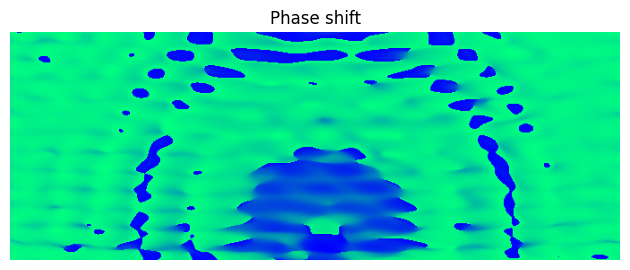

In [224]:
phase_shift = phase_map_ref - phase_map_im
phase_shift = np.mod(phase_shift, 2 * np.pi) # modulo 2pi

plot_image(phase_shift, title='Phase shift', cmap='winter') # arctic

Phase unwrap

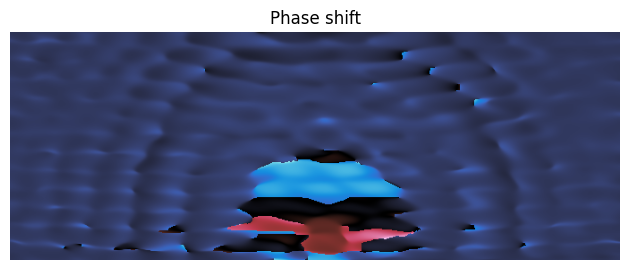

In [230]:
## --- Phase UNWRAP with step function algorithms ---
# openCV library

image_unwrapped = unwrap_phase(phase_shift, wrap_around=(False, False))
plot_image(image_unwrapped, title='Phase shift', cmap=cmr.redshift) # prinsenvlag, iceburn, redshift

Select single row
1. Get the function symmetrical along the middle

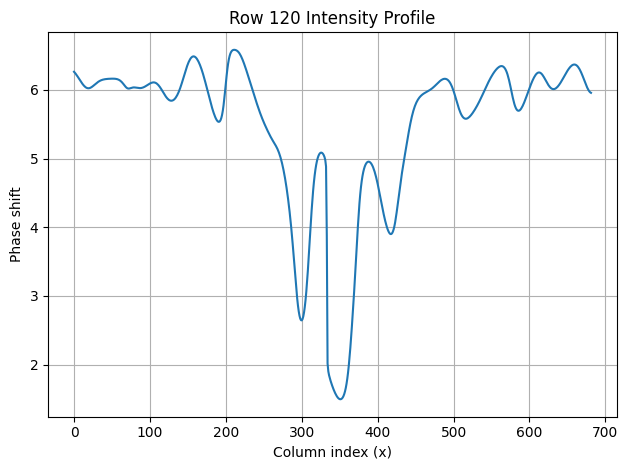

In [234]:
def plot_image_row(img: np.ndarray, row: int, title: str = None) -> None:
    """
    Plot the intensity profile of a single row of a 2D image.

    Parameters
    ----------
    img : 2D ndarray
        Input image (rows = height, cols = width).
    row : int
        Zero-based index of the row to plot (vertical coordinate).
    title : str, optional
        Plot title.
    """
    profile = img[row, :]            # grab the row (y = row, all x)
    plt.figure()
    plt.plot(profile)
    if title:
        plt.title(title)
    plt.xlabel("Column index (x)")
    plt.ylabel("Phase shift")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_image_row(image_unwrapped, row=250, title="Row 120 Intensity Profile")